# Predicting differences between local and benchmark decisions: Identifying patients that low thrombolsying units would not give thrombolysis to whereas the majority of benchmark hospitals would

## Plain English summary 

In this experiment we compare decisions between the top and bottom 30 hospitals (as ranked by the predicted thrombolysis use in the same 10k cohort of patients). We take those patients would would be given thrombolysis by the majority of the top 30 thombolysing hospitals (we also call these 'benchmark' hospitals), and predict when the bottom 30 hospitals would make a different decision (i.e. decide *not* to thrombolyse).

The XGBoost model used to make these predictions uses 8 features: 

* Arrival-to-scan time
* Infarction
* Stroke severity
* Precise onset time
* Prior disability level
* Stroke team
* Use of AF anticoagulants
* Onset-to-arrival time

We find that low thrombolysing hospitals are less likely to give thrombolysis to patients with:

* Low or very high stroke severity
* An estimated (not precise) stroke onset time
* Prior disability
* A longer arrival-to-scan time
* A longer inset-to-arrival time
* Use of of AF anticoagulants

## A note on Shap values

Shap values are usually reported as *log odds shifts* in model predictions. For a description of the relationships between probability, odds, and Shap values (log odds shifts) see [here](../introduction/odds_prob.md).

## Aims

* Of all those patients thrombolysed by benchmark decision, build an XGBoost model to predict which patients, would be *not* be thrombolysed at a local unit.
* Investigate model predictions using Shap.

## Observations

* We can predict those that will *not* receive thrombolysis at a local unit, out of those who will be thrombolysed by the majority of the benchmark hospitals, with 67% accuracy (AUC 0.733).

* The five most important distinguishing features are:
    * Stroke severity
    * Prior disability level
    * Precise onset time
    * Arrival-to-scan time
    * Onset-to-arrival time

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier

import json
import shap

## Function to calculate accuracy measures

In [2]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [3]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

In [4]:
thrombolysis_decision_data = pd.read_csv(
    './predictions/benchmark_decisions_combined_xgb_key_features.csv')

Add label where benchmark = 1, but observed = 0

In [5]:
thrombolysis_decision_data['benchmark_yes_observed_no'] = (
    (thrombolysis_decision_data['majority_vote'] == 1) &
    (thrombolysis_decision_data['observed'] == 0))

In [6]:
thrombolysis_decision_data

,unit,observed,predicted_thrombolysis,predicted_proba,majority_vote,benchmark_yes_observed_no
0,TXHRP7672C,1,1.0,0.880155,1.0,False
1,SQGXB9559U,1,1.0,0.627783,1.0,False
2,LFPMM4706C,0,0.0,0.042199,0.0,False
3,MHMYL4920B,0,0.0,0.000084,0.0,False
4,EQZZZ5658G,1,1.0,0.916311,1.0,False
...,...,...,...,...,...,...
88787,OYASQ1316D,1,1.0,0.917107,1.0,False
88788,SMVTP6284P,0,0.0,0.023144,0.0,False
88789,RDVPJ0375X,0,0.0,0.089444,0.0,False
88790,FAJKD7118X,0,1.0,0.615767,1.0,True


Combine with feature data for patients.

In [7]:
feature_data = pd.read_csv(
    './predictions/test_features_collated_key_features.csv')
feature_data.rename(columns=feature_name_dict, inplace=True)
feature_data['benchmark_yes_observed_no'] = \
    thrombolysis_decision_data['benchmark_yes_observed_no'] * 1
feature_data['majority_vote'] = \
    thrombolysis_decision_data['majority_vote'] * 1
feature_data['predicted_thrombolysis'] = \
    thrombolysis_decision_data['predicted_thrombolysis'] 
feature_data['observed'] = thrombolysis_decision_data['observed']

In [8]:
feature_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,Thrombolysis,benchmark_yes_observed_no,majority_vote,predicted_thrombolysis,observed
0,17.0,1,14.0,1,0,TXHRP7672C,0,186.0,1,0,1.0,1.0,1
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,1,0,1.0,1.0,1
2,138.0,1,2.0,1,0,LFPMM4706C,0,67.0,0,0,0.0,0.0,0
3,21.0,0,11.0,1,0,MHMYL4920B,0,86.0,0,0,0.0,0.0,0
4,8.0,1,16.0,1,0,EQZZZ5658G,0,83.0,1,0,1.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88787,3.0,1,11.0,1,1,OYASQ1316D,0,140.0,1,0,1.0,1.0,1
88788,69.0,1,3.0,0,4,SMVTP6284P,0,189.0,0,0,0.0,0.0,0
88789,63.0,1,3.0,1,1,RDVPJ0375X,0,154.0,0,0,0.0,0.0,0
88790,14.0,1,4.0,1,0,FAJKD7118X,0,77.0,0,1,1.0,1.0,0


## Load data on predicted 10k cohort thrombolysis use at each hospital
Use the hospitals thrombolysis rate on the same set of 10k patients to select the 30 hospitals with the lowest thrombolysis rates.

In [9]:
thrombolysis_by_hosp = pd.read_csv(
    './output/10k_thrombolysis_rate_by_hosp_key_features.csv', index_col='stroke_team')
thrombolysis_by_hosp.sort_values(
    'Thrombolysis rate', ascending=False, inplace=True)

In [10]:
low_thrombolysing_hospitals_df = thrombolysis_by_hosp.tail(30)
low_thrombolysing_hospitals = list(low_thrombolysing_hospitals_df.index)

## Build a model to distinguish between local and benchmark thrombolysis

In [11]:
# Restrict data to low thrombolysing hospitals and benchmark = yes and observed = no

mask = feature_data['Stroke team'].isin(low_thrombolysing_hospitals)
restricted_data = feature_data[mask]

# Get only patients thrombolysed in top 30
mask = restricted_data['majority_vote'] == 1
restricted_data = restricted_data[mask]

# Label those that are different
restricted_data['different_decision'] = restricted_data['Thrombolysis'] == 0

# Remove columnds not to be used in model
cols_to_drop = ['benchmark_yes_observed_no', 'predicted_thrombolysis',
               'majority_vote', 'observed', 'Thrombolysis']
restricted_data.drop(cols_to_drop, axis=1, inplace=True)


In [12]:
restricted_data

,Arrival-to-scan time,Infarction,Stroke severity,Precise onset time,Prior disability level,Stroke team,Use of AF anticoagulents,Onset-to-arrival time,different_decision
1,25.0,1,6.0,1,0,SQGXB9559U,0,71.0,False
28,38.0,1,13.0,1,0,DQKFO8183I,0,149.0,False
91,18.0,1,15.0,1,0,OUXUZ1084Q,0,122.0,True
154,21.0,1,5.0,1,0,WJHSV5358P,0,62.0,False
159,2.0,1,16.0,1,2,IATJE0497S,0,78.0,False
...,...,...,...,...,...,...,...,...,...
88667,66.0,1,16.0,1,0,LGNPK4211W,0,46.0,True
88698,5.0,1,16.0,1,2,ISIZF6614O,0,109.0,False
88740,10.0,1,5.0,1,0,NFBUF0424E,0,67.0,True
88758,9.0,1,3.0,1,0,ISIZF6614O,0,89.0,True


Show proportion of patients where the decision would differ between the low thrombolysing hospitals and the benchmark majority vote.

In [13]:
prop_diff = restricted_data['different_decision'].mean()
print (f'Proportion with predicted different decision: {prop_diff:.3f}')

Proportion with predicted different decision: 0.462


Set up X, Y and train/test split.

In [14]:
X = restricted_data.drop('different_decision', axis=1)
y = restricted_data['different_decision']
# Remove hospital ID
X.drop('Stroke team', axis=1, inplace=True)

In [15]:
skf = StratifiedKFold(n_splits = 5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)

# Set up list to store models
model_kfold = []

# Set up lists for k-fold fits
observed_kfold = []
predicted_proba_kfold = []
predicted_kfold = []
X_train_kfold = []
X_test_kfold = []
y_train_kfold = []
y_test_kfold = []

# Set up list for feature importances
importances_kfold = []

# Loop through the k-fold splits
k_fold = 0
for train_index, test_index in skf.split(X, y):
    k_fold += 1
    
    # Get X and Y train/test
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train_kfold.append(X_train)
    X_test_kfold.append(X_test)
    y_train_kfold.append(y_train)
    y_test_kfold.append(y_test)

    # Define model
    model = XGBClassifier(
        verbosity = 0, 
        scale_pos_weight=0.8, 
        random_state=42, 
        learning_rate=0.1)
    
    # Fit model
    model.fit(X_train, y_train)    
    model_kfold.append(model)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test)[:,1]
    predicted_proba_kfold.append(y_probs)
    observed_kfold.append(y_test)
    
    # Get feature importances
    importance = model.feature_importances_
    importances_kfold.append(importance)
    
    # Get class
    true_rate = np.mean(y_test)
    y_class = y_probs >= 0.5
    y_class = np.array(y_class) * 1.0
    predicted_kfold.append(y_class)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {k_fold}, accuracy: {accuracy:0.3f}')

Run 1, accuracy: 0.664
Run 2, accuracy: 0.670
Run 3, accuracy: 0.684
Run 4, accuracy: 0.664
Run 5, accuracy: 0.683


### Accuracy measures 

In [16]:
# Set up list for results
k_fold_results = []

# Loop through k fold predictions and get accuracy measures
for i in range(5):
    results = calculate_accuracy(observed_kfold[i], predicted_kfold[i])
    k_fold_results.append(results)
    
# Put results in DataFrame
accuracy_results = pd.DataFrame(k_fold_results).T

In [17]:
accuracy_results

,0,1,2,3,4
observed_positive_rate,0.461756,0.461756,0.461756,0.461248,0.461248
observed_negative_rate,0.538244,0.538244,0.538244,0.538752,0.538752
predicted_positive_rate,0.393768,0.351275,0.373938,0.360113,0.375236
predicted_negative_rate,0.606232,0.648725,0.626062,0.639887,0.624764
accuracy,0.663834,0.670444,0.683664,0.664461,0.683365
precision,0.659472,0.688172,0.694444,0.674541,0.692695
recall,0.562372,0.523517,0.562372,0.526639,0.563525
f1,0.607064,0.594657,0.621469,0.591484,0.621469
sensitivity,0.562372,0.523517,0.562372,0.526639,0.563525
specificity,0.750877,0.796491,0.787719,0.782456,0.785965


In [18]:
accuracy_results.T.describe()

,observed_positive_rate,observed_negative_rate,predicted_positive_rate,predicted_negative_rate,accuracy,precision,recall,f1,sensitivity,specificity,positive_likelihood,negative_likelihood,false_positive_rate,false_negative_rate,true_positive_rate,true_negative_rate,positive_predictive_value,negative_predictive_value
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.461553,0.538447,0.370866,0.629134,0.673154,0.681865,0.547685,0.607229,0.547685,0.780702,2.506552,0.579383,0.219298,0.452315,0.547685,0.780702,0.681865,0.668257
std,0.000279,0.000279,0.016221,0.016221,0.009804,0.014751,0.020672,0.014244,0.020672,0.017456,0.165878,0.023276,0.017456,0.020672,0.020672,0.017456,0.014751,0.008914
min,0.461248,0.538244,0.351275,0.606232,0.663834,0.659472,0.523517,0.591484,0.523517,0.750877,2.257409,0.555337,0.203509,0.436475,0.523517,0.750877,0.659472,0.658789
25%,0.461248,0.538244,0.360113,0.624764,0.664461,0.674541,0.526639,0.594657,0.526639,0.782456,2.420842,0.555563,0.212281,0.437628,0.526639,0.782456,0.674541,0.660844
50%,0.461756,0.538244,0.373938,0.626062,0.670444,0.688172,0.562372,0.607064,0.562372,0.785965,2.572456,0.582822,0.214035,0.437628,0.562372,0.785965,0.688172,0.666667
75%,0.461756,0.538752,0.375236,0.639887,0.683365,0.692695,0.562372,0.621469,0.562372,0.787719,2.632861,0.598227,0.217544,0.473361,0.562372,0.787719,0.692695,0.677225
max,0.461756,0.538752,0.393768,0.648725,0.683664,0.694444,0.563525,0.621469,0.563525,0.796491,2.649191,0.604968,0.249123,0.476483,0.563525,0.796491,0.694444,0.677761


### Receiver Operator Characteristic and Sensitivity-Specificity Curves

Receiver Operator Characteristic Curve:

In [19]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    fpr, tpr, thresholds = roc_curve(
        observed_kfold[i], predicted_proba_kfold[i])
    roc_auc = auc(fpr, tpr)
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')


Mean AUC: 0.7329
SD AUC: 0.0086


Sensitivity-specificity curve:

In [20]:
k_fold_sensitivity = []
k_fold_specificity = []

for i in range(5):
    # Get classificiation probabilities for k-fold replicate
    obs = observed_kfold[i]
    proba = predicted_proba_kfold[i]
    
    # Set up list for accuracy measures
    sensitivity = []
    specificity = []
    
    # Loop through increments in probability of survival
    thresholds = np.arange(0.0, 1.01, 0.01)
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get classificiation using cutoff
        predicted_class = proba >= cutoff
        predicted_class = predicted_class * 1.0
        # Call accuracy measures function
        accuracy = calculate_accuracy(obs, predicted_class)
        # Add accuracy scores to lists
        sensitivity.append(accuracy['sensitivity'])
        specificity.append(accuracy['specificity'])
    
    # Add replicate to lists
    k_fold_sensitivity.append(sensitivity)
    k_fold_specificity.append(specificity)

Combined plot:

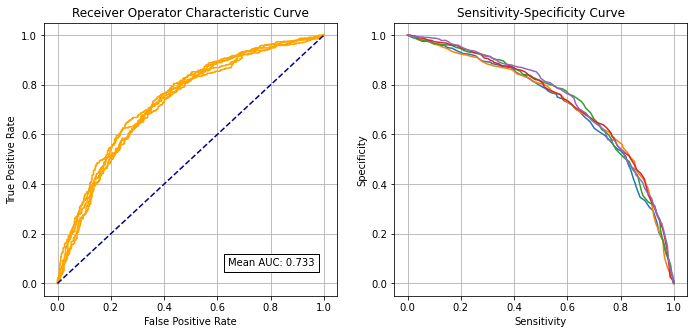

In [21]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
for i in range(5):
    ax2.plot(k_fold_sensitivity[i], k_fold_specificity[i])
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig('./output/decision_comparison_roc_sens_spec_key_features.jpg', dpi=300)

plt.show()

### Identify cross-over of sensitivity and specificity

In [22]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [23]:
intersections = []
for i in range(5):
    sens = np.array(k_fold_sensitivity[i])
    spec = np.array(k_fold_specificity[i])
    df = pd.DataFrame()
    df['sensitivity'] = sens
    df['specificity'] = spec
    df['spec greater sens'] = spec > sens

    # find last index for senitivity being greater than specificity 
    mask = df['spec greater sens'] == False
    last_id_sens_greater_spec = np.max(df[mask].index)
    locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
    points = df.iloc[locs][['sensitivity', 'specificity']]

    # Get intersetction with line of x=y
    a1 = list(points.iloc[0].values)
    a2 = list(points.iloc[1].values)
    b1 = [0, 0]
    b2 = [1, 1]

    intersections.append(get_intersect(a1, a2, b1, b2)[0])

mean_intersection = np.mean(intersections)
sd_intersection = np.std(intersections)
print (f'\nMean intersection: {mean_intersection:0.4f}')
print (f'SD intersection: {sd_intersection:0.4f}')


Mean intersection: 0.6764
SD intersection: 0.0063


## Shap values

We will look into detailed Shap values for the first train/test split.

### Get Shap values

In [24]:
k_fold_shap_values_extended = []
k_fold_shap_values = []

for k in range(5):
    
    # Set up explainer using typical feature values from training set
    explainer = shap.TreeExplainer(model_kfold[k], X_train_kfold[k])

    # Get Shapley values along with base and features
    shap_values_extended = explainer(X_test_kfold[k])
    k_fold_shap_values_extended.append(shap_values_extended)
    # Shap values exist for each classification in a Tree; 1=give thrombolysis
    shap_values = shap_values_extended.values
    k_fold_shap_values.append(shap_values)       

    print (f'Completed {k+1} of 5')

Completed 1 of 5
Completed 2 of 5
Completed 3 of 5
Completed 4 of 5
Completed 5 of 5


### Get average Shap values for each k-fold

In [25]:
shap_values_mean_kfold = []
features = list(X_train_kfold[0])

for k in range(5):
    shap_values = k_fold_shap_values[k]
    # Get mean Shap values for each feature
    shap_values_mean = pd.DataFrame(index=features)
    shap_values_mean['mean_shap'] = np.mean(shap_values, axis=0)
    shap_values_mean['abs_mean_shap'] = np.abs(shap_values_mean)
    shap_values_mean['mean_abs_shap'] = np.mean(np.abs(shap_values), axis=0)
    shap_values_mean['rank'] = shap_values_mean['mean_abs_shap'].rank(
        ascending=False).values
    shap_values_mean.sort_index()
    shap_values_mean_kfold.append(shap_values_mean)

### Examine consistency across top Shap values (mean |Shap|)

'Raw' Shap values from XGBoost model are log odds ratios. 

In [26]:
# Build df for k fold values
mean_abs_shap = pd.DataFrame()
for k in range(5):
    mean_abs_shap[f'{k}'] = shap_values_mean_kfold[k]['mean_abs_shap']
    
# Build df to show min, median, and max
mean_abs_shap_summary = pd.DataFrame()
mean_abs_shap_summary['min'] = mean_abs_shap.min(axis=1)
mean_abs_shap_summary['median'] = mean_abs_shap.median(axis=1) 
mean_abs_shap_summary['max'] = mean_abs_shap.max(axis=1)
mean_abs_shap_summary.sort_values('median', inplace=True, ascending=False)

In [27]:
top_10_shap = list(mean_abs_shap_summary.head(10).index)

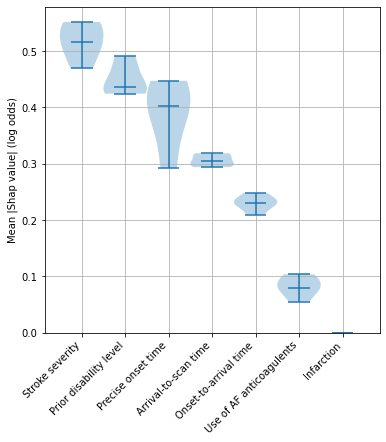

In [28]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(mean_abs_shap.loc[top_10_shap].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_shap
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Mean |Shap value| (log odds)')
plt.savefig('output/decision_comparison_shap_violin_key_features.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Examine consitency of feature importances

In [29]:
# Build df for k fold values
importances_df = pd.DataFrame()
for k in range(5):
    importances_df[f'{k}'] = importances_kfold[k]

# Build df to show min, median, and max
importances_summary = pd.DataFrame()
importances_summary['min'] = importances_df.min(axis=1)
importances_summary['median'] = importances_df.median(axis=1) 
importances_summary['max'] = importances_df.max(axis=1)
importances_summary.sort_values('median', inplace=True, ascending=False)
importance_features_index = list(importances_summary.index)
# Add feature names back in
importances_summary['feature'] = \
    [list(X_train)[feat] for feat in importance_features_index]
importances_summary.set_index('feature', inplace=True)

In [30]:
importances_summary

,min,median,max
feature,,,
Precise onset time,0.392276,0.427986,0.441626
Use of AF anticoagulents,0.202440,0.215143,0.226029
Prior disability level,0.164072,0.171589,0.180174
Stroke severity,0.084191,0.096703,0.102428
Arrival-to-scan time,0.046916,0.051572,0.056909
Onset-to-arrival time,0.042045,0.045115,0.050731
Infarction,0.000000,0.000000,0.000000


In [31]:
top_10_importances = list(importances_summary.head(10).index)

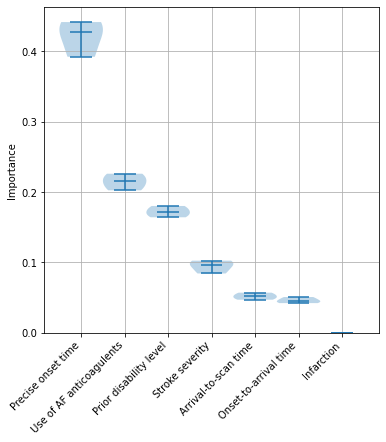

In [32]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.violinplot(importances_summary.loc[top_10_importances].T,
              showmedians=True,
              widths=1)
ax1.set_ylim(0)
labels = top_10_importances
ax1.set_xticks(np.arange(1, len(labels) + 1))
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(which='both')
ax1.set_ylabel('Importance')
plt.savefig('output/decision_comparison_importance_violin_key_features.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Compare Shap and importances

In [33]:
compare_shap_importance = pd.DataFrame()
compare_shap_importance['Shap'] = mean_abs_shap_summary.head(10).index
compare_shap_importance['Importance'] = importances_summary.head(10).index
compare_shap_importance

,Shap,Importance
0,Stroke severity,Precise onset time
1,Prior disability level,Use of AF anticoagulents
2,Precise onset time,Prior disability level
3,Arrival-to-scan time,Stroke severity
4,Onset-to-arrival time,Arrival-to-scan time
5,Use of AF anticoagulents,Onset-to-arrival time
6,Infarction,Infarction


In [34]:
shap_importance = pd.DataFrame()
shap_importance['Shap'] = mean_abs_shap_summary['median']
shap_importance = shap_importance.merge(
    importances_summary['median'], left_index=True, right_index=True)
shap_importance.rename(columns={'median':'Importance'}, inplace=True)
shap_importance.sort_values('Shap', inplace=True, ascending=False)
shap_importance.head(10)

,Shap,Importance
Stroke severity,0.515694,0.096703
Prior disability level,0.436681,0.171589
Precise onset time,0.401897,0.427986
Arrival-to-scan time,0.304198,0.051572
Onset-to-arrival time,0.230033,0.045115
Use of AF anticoagulents,0.079052,0.215143
Infarction,0.000000,0.000000


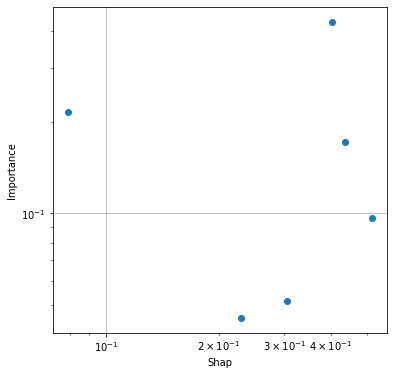

In [35]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(shap_importance['Shap'],
            shap_importance['Importance'])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Shap')
ax1.set_ylabel('Importance')
ax1.grid()
plt.savefig(
    'output/decision_comparison_shap_importance_correlation_key_features.jpg',
    dpi=300)
plt.show()

## Further analysis of one k-fold

Having established that Shap values have good consistency across k-fold replictaes, here we show more detail on Shap using the first k_fold replicate.

In [36]:
# Get all key values from first k fold
model = model_kfold[0]
shap_values = k_fold_shap_values[0]
shap_values_extended = k_fold_shap_values_extended[0]
importances = importances_kfold[0]
y_pred = predicted_kfold[0]
y_prob = predicted_proba_kfold[0]
X_train = X_train_kfold[0]
X_test = X_test_kfold[0]
y_train = y_train_kfold[0]
y_test = y_test_kfold[0]

### Beeswarm plot

A Beeswarm plot shows all points. The feature value for each point is shown by the colour, and its position indicates the Shap value for that instance.

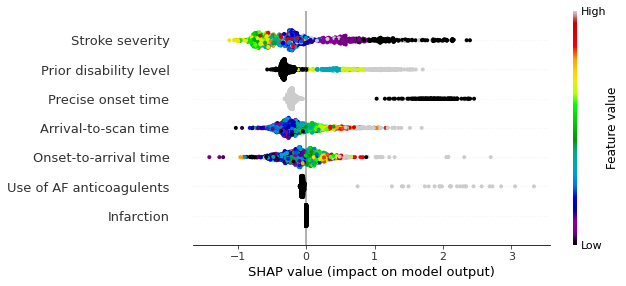

In [37]:
fig = plt.figure(figsize=(6,6))

shap.summary_plot(shap_values=shap_values, 
                  features=X_test,
                  feature_names=features,
                  max_display=8,
                  cmap=plt.get_cmap('nipy_spectral'), show=False)
plt.savefig('output/xgb_decision_comparison_beeswarm_key_features.jpg', 
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Plot Waterfall and decision plot plots for instances with low or high probability of making a different decision

Waterfall plot and decision plots are alternative ways of plotting the influence of features for individual cases.

In [38]:
# Get the location of an example each of low and high probablility
location_high_probability = np.where(y_prob == np.max(y_prob))[0][0]

An example with high probability of a low thrombolysing unit making deciding not to give thrombolysis to a patient when the benchmark hospitals would.

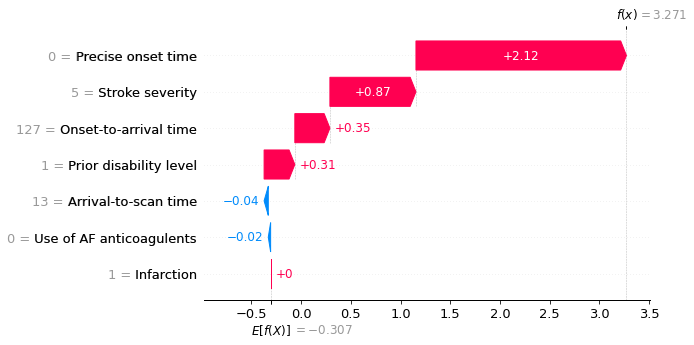

In [39]:
fig = shap.plots.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8)
plt.savefig('output/xgb_decision_comparison_waterfall_high_key_features.jpg',
            dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

### Show the relationship between feature value and Shap value for influential features.

#### Show Shap as a scatter plot

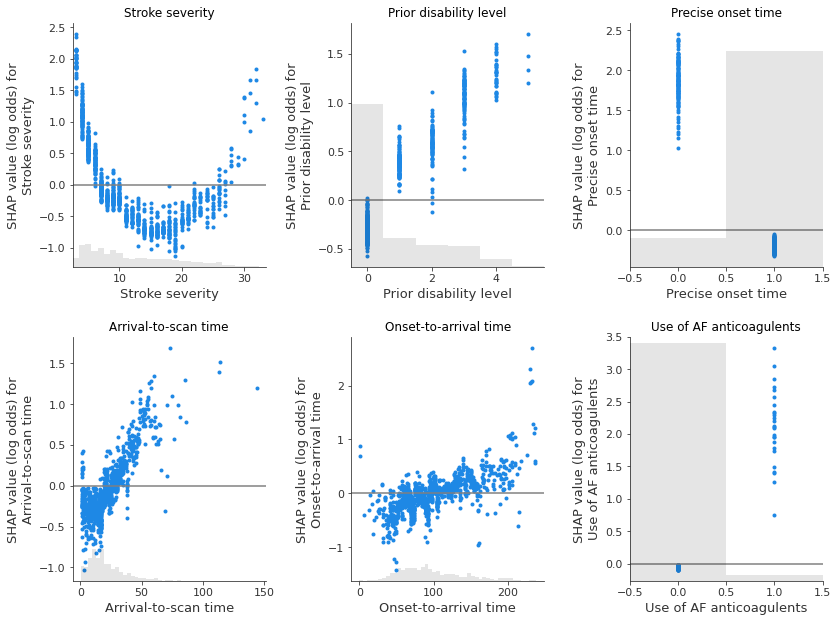

In [40]:
feat_to_show = top_10_shap[0:6]

fig = plt.figure(figsize=(12,9))
for n, feat in enumerate(feat_to_show):    
    ax = fig.add_subplot(2,3,n+1)
    shap.plots.scatter(shap_values_extended[:, feat], x_jitter=0, ax=ax, 
                       show=False)
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0,0], c='0.5')    
    
    ax.set_ylabel(f'SHAP value (log odds) for\n{feat}')
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig('output/xgb_prediciting_difference_shap_scatter.jpg', dpi=300,
    bbox_inches='tight', pad_inches=0.2)

#### Show Shap as a violin plot

In [41]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    rotation [integer] = xtick label rotation
    feat [string] = used in the axis label, the feature that is being plotted
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=10)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'Shap values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

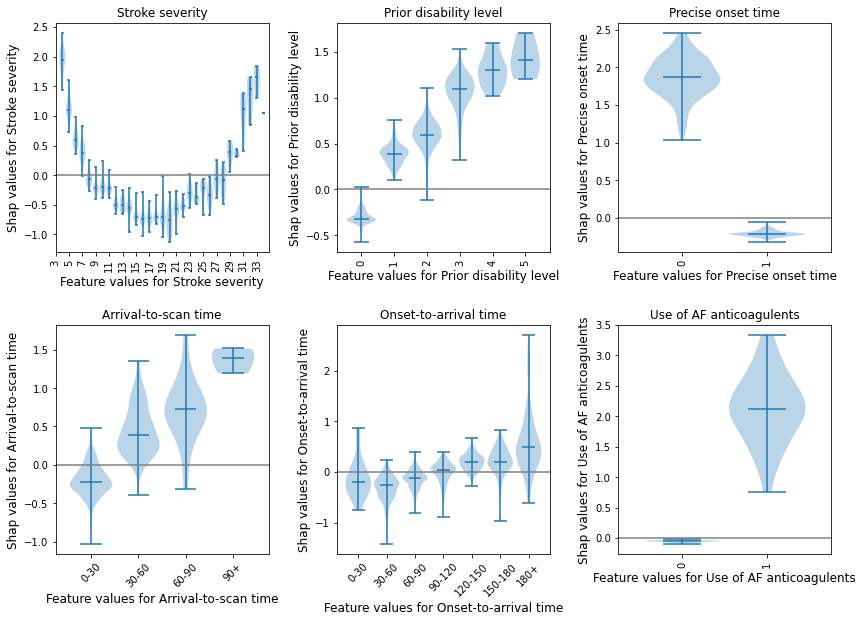

In [42]:
feat_to_show = top_10_shap[0:6]

fig = plt.figure(figsize=(12,9))
# for each feature, prepare the data for the violin plot.
# data either already in categories, or if there's more than 50 unique values
# for a feature then assume it needs to be binned, and a violin for each bin
for n, feat in enumerate(feat_to_show):    
    feature_data = shap_values_extended[:, feat].data
    feature_shap = shap_values_extended[:, feat].values

    # if feature has more that 50 unique values, then assume it needs to be 
    # binned (other assume they are unique categories)
    if np.unique(feature_data).shape[0] > 50:
        # bin the data, create a violin per bin
        
        # settings for the plot
        rotation = 45
        step = 30
        n_bins = min(16, np.int((feature_data.max())/step))
        
        # create list of bin values
        bin_list = [(i*step) for i in range(n_bins)]
        bin_list.append(feature_data.max())

        # create list of bins (the unique categories)
        category_list =  [f'{i*step}-{(i+1)*step}' for i in range(n_bins-1)]
        category_list.append(f'{(n_bins-1)*step}+')

        # bin the feature data
        feature_data = pd.cut(feature_data, bin_list, labels=category_list)

    else:
        # create a violin per unique value
        
        # settings for the plot
        rotation = 90
        
        # create list of unique categories in the feature data
        category_list = np.unique(feature_data)
        category_list = [int(i) for i in category_list]

    # create a list, each entry contains the corresponsing Shap value for that 
    # category (or bin). A violin will represent each list.    
    shap_per_category = []
    for category in category_list:
        mask = feature_data == category
        shap_per_category.append(feature_shap[mask])

    # create violin plot
    ax = fig.add_subplot(2, 3 ,n+1)
    ax.violinplot(shap_per_category, showmedians=True, widths=0.9)    
    
    # Add line at Shap = 0
    feature_values = shap_values_extended[:, feat].data
    ax.plot([0, len(feature_values)], [0,0],c='0.5')   

    # customise the axes
    ax = set_ax(ax, category_list, feat, rotation=rotation)
    plt.subplots_adjust(bottom=0.15, wspace=0.05)
    
    # Adjust stroke severity tickmarks
    if feat == 'Stroke severity':
        ax.set_xticks(np.arange(0, len(category_list), 2))
        ax.set_xticklabels(category_list[0::2])        
    
    # Add title
    ax.set_title(feat)
    
plt.tight_layout(pad=2)
    
fig.savefig(
    f'output/xgb_predicting_difference_shap_violin.jpg', dpi=300,
     bbox_inches='tight', pad_inches=0.2)

## Showing waterfall plots using probability values

Though Shap values for XGBoost most accurately describe the effect on log odds ratio of classification, it may be easier for people to understand influence of features using probabilities. Here we plot waterfall plots using probabilities.

A disadvantage of this method is that it distorts the influence of features someone - those features pushing the probability down from a low level to an even lower level get 'squashed' in apparent importance. This distortion is avoided when plotting log odds ratio, but at the cost of using an output that is poorly understandable by many.

In [43]:
# Set up explainer using typical feature values from training set
explainer = shap.TreeExplainer(model, X_train, model_output='probability')

# Get Shapley values along with base and features
shap_values_extended = explainer(X_test)
shap_values = shap_values_extended.values

In [44]:
# Get the location of an example each of low and high probablility

location_high_probability = np.where(y_prob==np.max(y_prob))[0][0]

An example with high probability of a low thrombolysing unit making deciding not to give thrombolysis to a patient when the benchmark hospitals would.

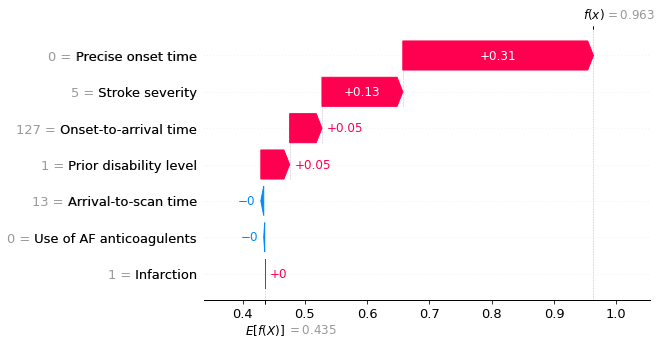

In [45]:
fig = shap.plots.waterfall(shap_values_extended[location_high_probability],
                           show=False, max_display=8)
plt.savefig(
    'output/xgb_decision_comparison_waterfall_high_probability_key_features.jpg', 
    dpi=300, bbox_inches='tight', pad_inches=0.2)
plt.show()

## Observations

* We can predict those that will *not* receive thrombolysis at a local unit, out of those who will be thrombolysed by the majority of the benchmark hospitals, with 67% accuracy (AUC 0.733).

* The five most important distinguishing features are:
    * Stroke severity
    * Prior disability level
    * Precise onset time
    * Arrival-to-scan time
    * Onset-to-arrival time